In [59]:
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Embedding
from keras.layers import LSTM, SimpleRNN, GRU
from keras.models import Sequential
from sklearn.metrics import precision_score, recall_score, f1_score

# from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import keras_tuner as kt

from tensorflow.keras.optimizers import Adam, RMSprop
from nltk import word_tokenize, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from gensim import models

import string, re
import nltk
import numpy as np
import pandas as pd
import os
import collections
from string import punctuation

### Dataset generation using ollama - 

In [ ]:
import ollama
import pandas as pd
import random
import os

# Define sentiment categories
sentiments = ["positive", "negative", "neutral"]

# Predefined contexts
contexts = [
    "Business and Professional", "Travel and Tourism", "Social and Personal",
    "Technology and Gadgets", "Education and Learning", "Healthcare and Wellness",
    "Entertainment and Media", "Food and Dining", "Sports and Fitness",
    "Environmental and Sustainability", "Retail and E-commerce", "Customer Support and Service",
    "Financial and Investment", "Public Transportation and Commute", "Real Estate and Housing",
    "Education and Teaching", "Government and Politics", "Hobbies and Leisure Activities",
    "Fashion and Beauty", "Pets and Animal Care"
]

# Number of samples per sentiment
num_samples = 200 

# List to store generated data
data = []

# Generate sentences for each sentiment and context
for sentiment in sentiments:
    for _ in range(num_samples):
        context = random.choice(contexts)  # Pick a random context
        prompt = f"Generate a short sentence expressing a {sentiment} sentiment in the context of {context}."
        response = ollama.chat(model="mistral", messages=[{"role": "user", "content": prompt}])
        generated_text = response['message']['content']
        data.append([generated_text, sentiment])

# Convert new data to DataFrame
new_df = pd.DataFrame(data, columns=["text", "sentiment"])

# Check if the file already exists
file_path = "generated_dataset.csv"
if os.path.exists(file_path):
    # Load existing data
    existing_df = pd.read_csv(file_path)
    # Append new data to existing data
    combined_df = pd.concat([existing_df, new_df], ignore_index=True)
else:
    # If the file doesn't exist, use only the new data
    combined_df = new_df

# Save the combined dataset to CSV
combined_df.to_csv(file_path, index=False, encoding="utf-8")

print(f"Dataset updated and saved to {file_path}")

### Load data

In [72]:
cleaned_file_path = "data/cleaned_sentiment_dataset-old.csv"
df_cleaned = pd.read_csv(cleaned_file_path)
print(df_cleaned.sentiment.unique())
print(df_cleaned.shape)

['positive' 'negative' 'neutral']
(1458, 2)


### Class Distribution

Total number of rows: 1458
sentiment
negative    489
positive    486
neutral     483
Name: count, dtype: int64


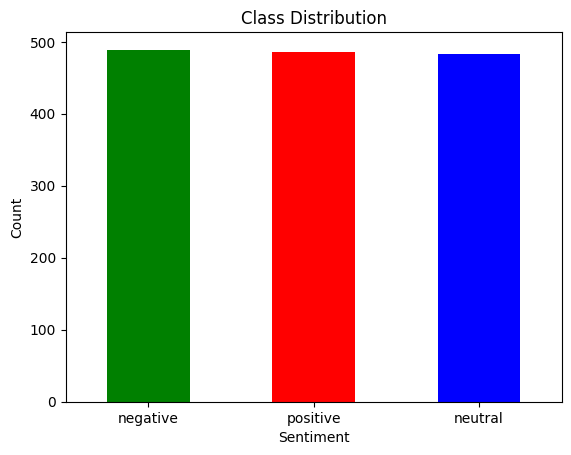

In [120]:
# Count occurrences of each sentiment class
class_distribution = df_cleaned["sentiment"].value_counts()
# Get total number of rows
total_rows = len(df_cleaned)
print(f"Total number of rows: {total_rows}")
# Display results
print(class_distribution)
# Plot class distribution
class_distribution.plot(kind="bar", color=["green", "red", "blue"])
plt.title("Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.xticks(rotation=0)
# plt.grid(axis="y")
plt.show()

### Data preprocessing

In [73]:
#convert the sentiment labels in df_cleaned["sentiment"] into one-hot encoded
pos = []
neg = []
neut = []
for sent in df_cleaned.sentiment:
    if sent == "positive":
        pos.append(1)
        neg.append(0)
        neut.append(0)
    elif sent == "negative":
        pos.append(0)
        neg.append(1)
        neut.append(0)
    elif sent == "neutral":
        pos.append(0)
        neg.append(0)
        neut.append(1)

# create new columns
df_cleaned['Pos']= pos
df_cleaned['Neg']= neg
df_cleaned['Neut']=neut

# print few rows
df_cleaned.tail()

,text,sentiment,Pos,Neg,Neut
1453,"""Painting can be an enjoyable hobby for many ...",neutral,0,0,1
1454,"""The latest online shopping data indicates st...",neutral,0,0,1
1455,"""Using this new smartphone's voice assistant ...",neutral,0,0,1
1456,"""The learning environment is conducive to bot...",neutral,0,0,1
1457,"""The restaurant offers a variety of dishes, e...",neutral,0,0,1


In [74]:
# remove punctuation
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

df_cleaned['Text_Clean'] = df_cleaned['text'].apply(lambda x: remove_punct(x))

# confirm punctuation is removed
print(df_cleaned.Text_Clean.tail())

1453     Painting can be an enjoyable hobby for many d...
1454     The latest online shopping data indicates ste...
1455     Using this new smartphones voice assistant fu...
1456     The learning environment is conducive to both...
1457     The restaurant offers a variety of dishes ens...
Name: Text_Clean, dtype: object


In [10]:
# Download nlt packages

nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('stopwords')

In [75]:
# Tokenize each sentence in the "Text_Clean" column
tokens = [word_tokenize(sen) for sen in df_cleaned.Text_Clean]

# Function to convert all tokens to lowercase
def lower_token(tokens): 
    return [w.lower() for w in tokens]    

# Apply lowercasing to all tokenized sentences
lower_tokens = [lower_token(token) for token in tokens] 

# Load the list of English stopwords
stoplist = stopwords.words('english')

# Function to remove stopwords from a list of tokens
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stoplist]

# Apply stopword removal to all tokenized sentences
filtered_words = [remove_stop_words(sen) for sen in lower_tokens] 

# Convert the filtered token lists back into sentences
result = [' '.join(sen) for sen in filtered_words]

# update the df
df_cleaned['Text_Final'] = result
df_cleaned['tokens'] = filtered_words
df_cleaned = df_cleaned[['Text_Final', 'tokens', 'sentiment', 'Pos', 'Neg','Neut']]
df_cleaned.head()

,Text_Final,tokens,sentiment,Pos,Neg,Neut
0,passion engagement demonstrated last nights de...,"[passion, engagement, demonstrated, last, nigh...",positive,1,0,0
1,exploring song lyrics different genres opens w...,"[exploring, song, lyrics, different, genres, o...",positive,1,0,0
2,im really impressed quickly able solve problem...,"[im, really, impressed, quickly, able, solve, ...",positive,1,0,0
3,exploring song lyrics reveals rich tapestry em...,"[exploring, song, lyrics, reveals, rich, tapes...",positive,1,0,0
4,hear new solar farm built town great step towa...,"[hear, new, solar, farm, built, town, great, s...",positive,1,0,0


In [14]:
# # Save cleaned dataset
# cleaned_file_path = "data/cleaned_sentiment_dataset.csv"
# df_cleaned.to_csv(cleaned_file_path, index=False, encoding="utf-8")

### Data splitting

In [76]:
# split data into training and testing sets
data_train, data_test = train_test_split(df_cleaned, test_size=0.10, random_state=42)

In [61]:
# analyze the vocabulary and sentence lengths in the training dataset
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

17029 words total, with a vocabulary size of 3641
Max sentence length is 213


In [77]:
# analyze the vocabulary and sentence lengths in the test dataset
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

2993 words total, with a vocabulary size of 1402
Max sentence length is 161


In [63]:
# create embeddings using word2vec
word2vec_path = 'GoogleNews-vectors-negative300.bin.gz'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [78]:
# Function to compute the average Word2Vec vector for a list of tokens
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    """
    Computes the average Word2Vec embedding for a given list of tokens.
    
    Parameters:
    - tokens_list: List of words (tokens) for a given sentence.
    - vector: Pre-trained Word2Vec model (word embeddings).
    - generate_missing: If True, generates a random vector for missing words.
    - k: Dimension of word vectors (default is 300).

    Returns:
    - Averaged Word2Vec embedding for the given list of words.
    """
    
    # If the token list is empty, return a zero vector of size k
    if len(tokens_list) < 1:
        return np.zeros(k)
    
    # Generate word vectors: If a word is missing, either use a random vector or a zero vector
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]

    # Compute the sum of all word vectors
    summed = np.sum(vectorized, axis=0)
    
    # Compute the average word vector by dividing the sum by the number of words
    averaged = np.divide(summed, len(vectorized))
    
    return averaged


# Function to generate Word2Vec embeddings for an entire dataset
def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    """
    Generates Word2Vec embeddings for a dataset containing preprocessed text.

    Parameters:
    - vectors: Pre-trained Word2Vec model.
    - clean_comments: Pandas DataFrame with a 'tokens' column (tokenized text).
    - generate_missing: If True, generates random vectors for missing words.

    Returns:
    - List of sentence-level Word2Vec embeddings.
    """
    
    # Apply the get_average_word2vec function to each row in the 'tokens' column
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    
    return list(embeddings)


In [79]:
# Generate Word2Vec embeddings for the training dataset
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

# Define constants
MAX_SEQUENCE_LENGTH = 50  # Maximum length of a sequence (sentence) after padding
EMBEDDING_DIM = 300       # Word embedding dimension (matches Word2Vec size)

# Initialize a tokenizer for converting text to numerical sequences
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)

# Fit the tokenizer on the training text data
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())

# Convert text data into sequences of token indices
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

# Get the word index mapping (word to integer mapping)
train_word_index = tokenizer.word_index

# Print the total number of unique tokens found in the dataset
print('Found %s unique tokens.' % len(train_word_index))


Found 4311 unique tokens.


In [80]:
# Pad training sequences to ensure uniform input size
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Initialize embedding weight matrix with zeros
train_embedding_weights = np.zeros((len(train_word_index) + 1, EMBEDDING_DIM))

# Populate the embedding weight matrix with pre-trained Word2Vec vectors
for word, index in train_word_index.items():
    # If the word exists in the Word2Vec model, use its vector
    # Otherwise, assign a random vector of size EMBEDDING_DIM
    train_embedding_weights[index, :] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)

# Print the shape of the embedding matrix to confirm correct initialization
print(train_embedding_weights.shape)  

# Convert test data into sequences of token indices
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())

# Pad test sequences to match training input size
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)



(4312, 300)


In [81]:
# labels
label_names = ['Pos', 'Neg','Neut']
y_train = data_train[label_names].values
x_train = train_cnn_data
y_tr = y_train

# print results
print(train_embedding_weights.shape)
print("Number of unique tokens in tokenizer:", len(train_word_index))


(4312, 300)
Number of unique tokens in tokenizer: 4311


### Define and Train the three models

In [105]:
def recurrent_nn(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, variant='lstm'):
    # Define the embedding layer
    embedding_layer = Embedding(num_words,
                                embedding_dim,
                                weights=[embeddings],
                                input_length=max_sequence_length,
                                trainable=False)
    
    # Input layer
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    
    # RNN, LSTM, or GRU layer depending on the variant
    if variant == 'rnn':
        rnn_layer = SimpleRNN(256, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
    elif variant == 'lstm':
        rnn_layer = LSTM(256, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
    elif variant == 'gru':
        rnn_layer = GRU(256, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)
    else:
        raise ValueError("Variant must be 'rnn', 'lstm', or 'gru'")

    # Dense layers
    x = Dense(128, activation='relu')(rnn_layer)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    # Define and compile the model
    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model


In [106]:
# Train RNN, LSTM, and GRU models
model_rnn = recurrent_nn(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index) + 1, EMBEDDING_DIM, len(label_names), variant='rnn')
model_lstm = recurrent_nn(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index) + 1, EMBEDDING_DIM, len(label_names), variant='lstm')
model_gru = recurrent_nn(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index) + 1, EMBEDDING_DIM, len(label_names), variant='gru')

# Train each model
num_epochs = 20
batch_size = 10

hist_rnn = model_rnn.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)
hist_lstm = model_lstm.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)
hist_gru = model_gru.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)


c:\Users\ELIZABETH\anaconda3\envs\tf_env\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)     │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_19 (Embedding)        │ (None, 50, 300)        │     1,293,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 256)            │       142,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,469,475 (5.61 MB)

 Trainable params: 175,875 (687.01 KB)

 Non-trainable params: 1,293,600 (4.93 MB)

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_20 (Embedding)        │ (None, 50, 300)        │     1,293,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 256)            │       570,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,897,251 (7.24 MB)

 Trainable params: 603,651 (2.30 MB)

 Non-trainable params: 1,293,600 (4.93 MB)

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_21 (InputLayer)     │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_21 (Embedding)        │ (None, 50, 300)        │     1,293,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 256)            │       428,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,755,427 (6.70 MB)

 Trainable params: 461,827 (1.76 MB)

 Non-trainable params: 1,293,600 (4.93 MB)

Epoch 1/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - acc: 0.4010 - loss: 1.1058 - val_acc: 0.4167 - val_loss: 1.0660
Epoch 2/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - acc: 0.5093 - loss: 0.9574 - val_acc: 0.5606 - val_loss: 0.8552
Epoch 3/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.6198 - loss: 0.8441 - val_acc: 0.6818 - val_loss: 0.7507
Epoch 4/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - acc: 0.6054 - loss: 0.8477 - val_acc: 0.7576 - val_loss: 0.5602
Epoch 5/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - acc: 0.7407 - loss: 0.6241 - val_acc: 0.8106 - val_loss: 0.5080
Epoch 6/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - acc: 0.7924 - loss: 0.5178 - val_acc: 0.7348 - val_loss: 0.6505
Epoch 7/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - acc: 0.7823 - loss: 0.5621 - val_acc: 0.8182 - val_loss: 0.4469
Epoch 8/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - acc: 0.8229 - loss: 0.4475 - val_acc: 0.8712 - val_loss: 0.3709
Epoch 9/20
118/118 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/

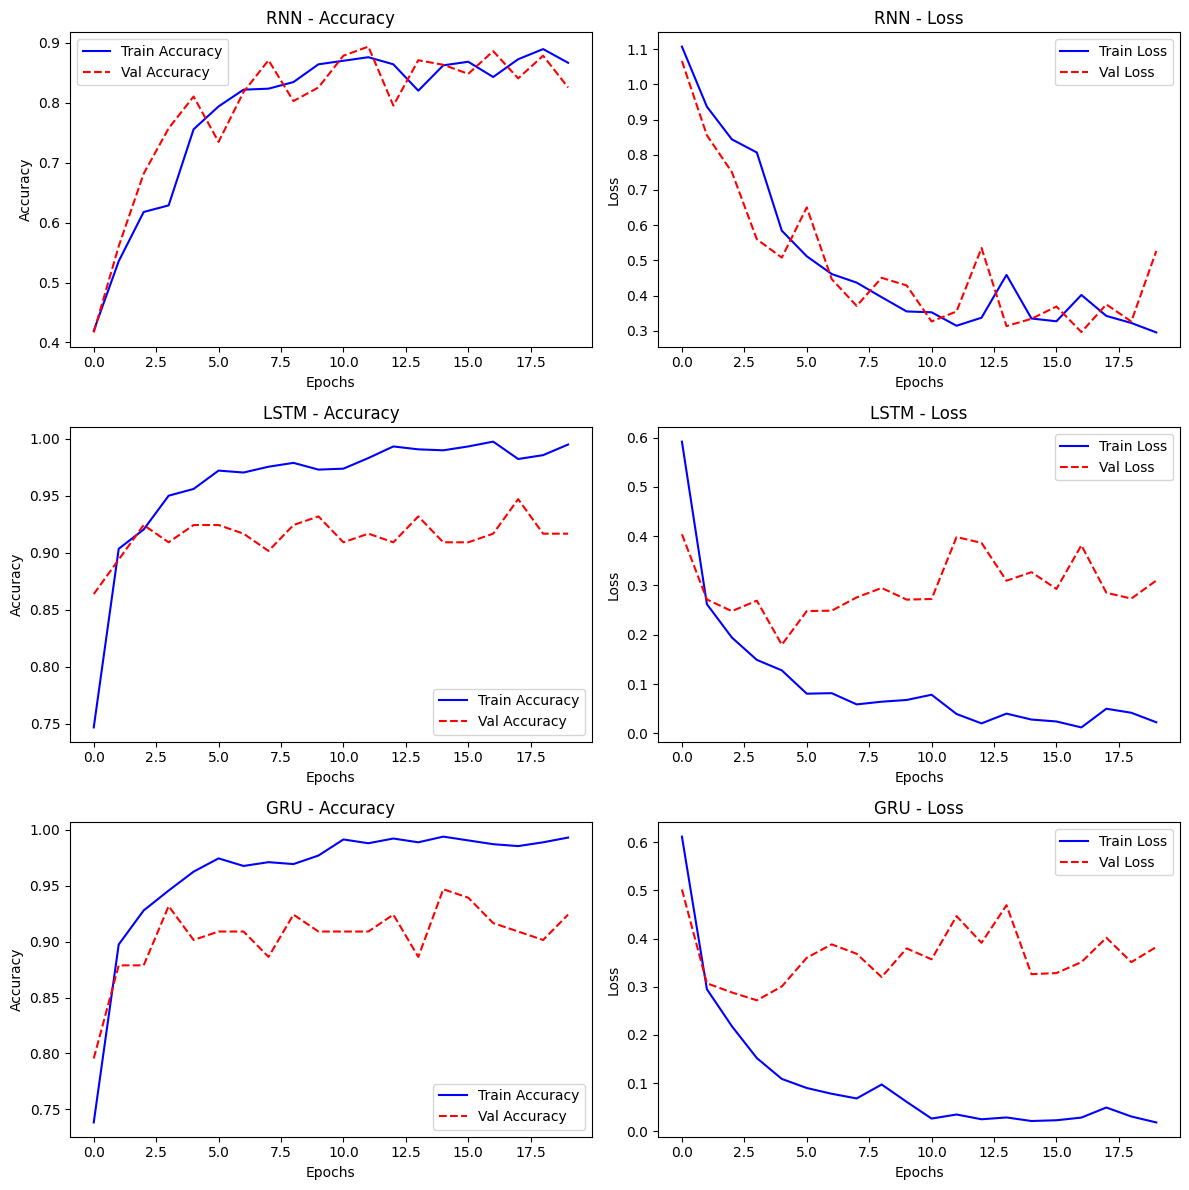

In [107]:
# Function to plot training vs validation accuracy and loss
def plot_training_history(histories, labels):
    fig, axes = plt.subplots(nrows=len(histories), ncols=2, figsize=(12, 4 * len(histories)))

    for i, (history, label) in enumerate(zip(histories, labels)):
        # Accuracy Plot
        axes[i, 0].plot(history.history['acc'], label='Train Accuracy', color='blue')
        axes[i, 0].plot(history.history['val_acc'], linestyle='dashed', label='Val Accuracy', color='red')
        axes[i, 0].set_xlabel('Epochs')
        axes[i, 0].set_ylabel('Accuracy')
        axes[i, 0].set_title(f'{label} - Accuracy')
        axes[i, 0].legend()
        axes[i, 0].grid(False)

        # Loss Plot
        axes[i, 1].plot(history.history['loss'], label='Train Loss', color='blue')
        axes[i, 1].plot(history.history['val_loss'], linestyle='dashed', label='Val Loss', color='red')
        axes[i, 1].set_xlabel('Epochs')
        axes[i, 1].set_ylabel('Loss')
        axes[i, 1].set_title(f'{label} - Loss')
        axes[i, 1].legend()
        axes[i, 1].grid(False)

    plt.tight_layout()
    plt.show()

# Call function with the histories
plot_training_history([hist_rnn, hist_lstm, hist_gru], ['RNN', 'LSTM', 'GRU'])


### Model performance before hyperparameter tuning

In [108]:
import numpy as np
label_map = {
    "positive": "Pos",
    "negative": "Neg",
    "neutral": "Neut"
}
# Function to convert probabilities to predicted labels
def get_labels(predictions):
    return [label_names[np.argmax(p)] for p in predictions]

# Make predictions on the test data
test_predictions_rnn = model_rnn.predict(test_cnn_data, batch_size=1024, verbose=1)
test_predictions_lstm = model_lstm.predict(test_cnn_data, batch_size=1024, verbose=1)
test_predictions_gru = model_gru.predict(test_cnn_data, batch_size=1024, verbose=1)

# Convert probabilities to predicted labels
predicted_labels_rnn = get_labels(test_predictions_rnn)
predicted_labels_lstm = get_labels(test_predictions_lstm)
predicted_labels_gru = get_labels(test_predictions_gru)

# Convert actual labels to match predicted format
true_labels = data_test['sentiment'].map(label_map)

# Calculate accuracy using NumPy
accuracy_rnn = np.mean(np.array(true_labels) == np.array(predicted_labels_rnn))
accuracy_lstm = np.mean(np.array(true_labels) == np.array(predicted_labels_lstm))
accuracy_gru = np.mean(np.array(true_labels) == np.array(predicted_labels_gru))

# Print results
print(f"✅ RNN Accuracy (Before Tuning): {accuracy_rnn:.4f}")
print(f"✅ LSTM Accuracy (Before Tuning): {accuracy_lstm:.4f}")
print(f"✅ GRU Accuracy (Before Tuning): {accuracy_gru:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step
✅ RNN Accuracy (Before Tuning): 0.8973
✅ LSTM Accuracy (Before Tuning): 0.9452
✅ GRU Accuracy (Before Tuning): 0.9452


In [109]:
from sklearn.metrics import classification_report

print("RNN Classification Report:")
print(classification_report(true_labels, predicted_labels_rnn, target_names=label_names))

print("LSTM Classification Report:")
print(classification_report(true_labels, predicted_labels_lstm, target_names=label_names))

print("GRU Classification Report:")
print(classification_report(true_labels, predicted_labels_gru, target_names=label_names))

RNN Classification Report:
              precision    recall  f1-score   support

         Pos       1.00      0.92      0.96        49
         Neg       0.90      0.81      0.85        47
        Neut       0.81      0.96      0.88        50

    accuracy                           0.90       146
   macro avg       0.91      0.90      0.90       146
weighted avg       0.91      0.90      0.90       146

LSTM Classification Report:
              precision    recall  f1-score   support

         Pos       0.98      0.94      0.96        49
         Neg       0.90      0.94      0.92        47
        Neut       0.96      0.96      0.96        50

    accuracy                           0.95       146
   macro avg       0.95      0.94      0.94       146
weighted avg       0.95      0.95      0.95       146

GRU Classification Report:
              precision    recall  f1-score   support

         Pos       1.00      0.94      0.97        49
         Neg       0.87      0.98      0.92    

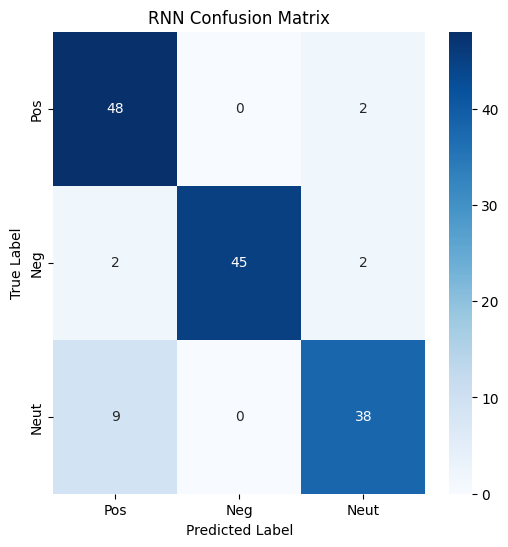

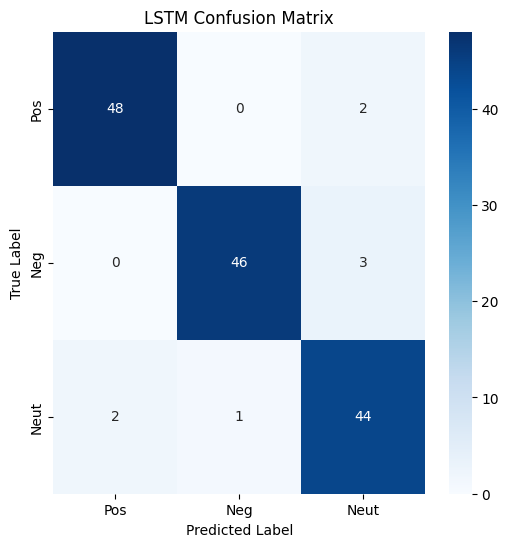

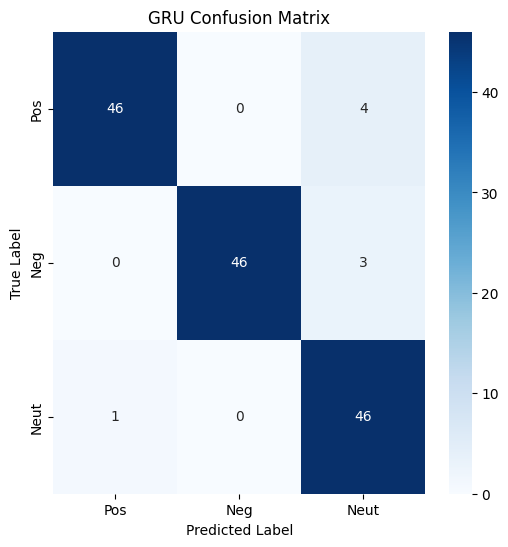

In [110]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(true_labels, predicted_labels, variant):
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=label_names)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.title(f'{variant.upper()} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot confusion matrices for RNN, LSTM, and GRU
plot_confusion_matrix(true_labels, predicted_labels_rnn, 'rnn')
plot_confusion_matrix(true_labels, predicted_labels_lstm, 'lstm')
plot_confusion_matrix(true_labels, predicted_labels_gru, 'gru')

      Accuracy  Precision    Recall  F1-Score
RNN   0.897260   0.905492  0.897260  0.897852
LSTM  0.945205   0.946312  0.945205  0.945491
GRU   0.945205   0.950196  0.945205  0.945995


<Figure size 1000x600 with 0 Axes>

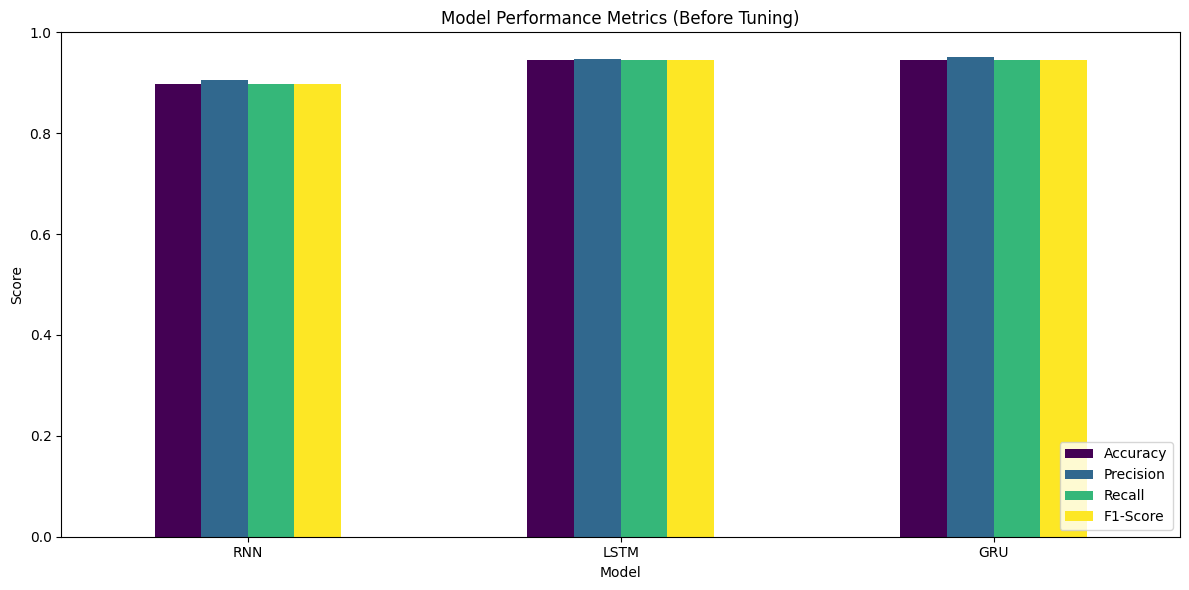

In [111]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to calculate metrics
def calculate_metrics(true_labels, predicted_labels):
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    return accuracy, precision, recall, f1

# Calculate metrics for each model
metrics_rnn = calculate_metrics(true_labels, predicted_labels_rnn)
metrics_lstm = calculate_metrics(true_labels, predicted_labels_lstm)
metrics_gru = calculate_metrics(true_labels, predicted_labels_gru)

# Store metrics in a dictionary
metrics_dict = {
    'RNN': metrics_rnn,
    'LSTM': metrics_lstm,
    'GRU': metrics_gru
}

# Convert metrics to a DataFrame for easier plotting
import pandas as pd

metrics_df = pd.DataFrame(metrics_dict, index=['Accuracy', 'Precision', 'Recall', 'F1-Score']).T
print(metrics_df)

# Plot bar graphs
def plot_metrics_bar(metrics_df):
    plt.figure(figsize=(10, 6))
    metrics_df.plot(kind='bar', figsize=(12, 6), colormap='viridis')
    plt.title('Model Performance Metrics (Before Tuning)')
    plt.ylabel('Score')
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.ylim(0, 1)  # Metrics range from 0 to 1
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

# Plot the bar graph
plot_metrics_bar(metrics_df)

## Perform Hyperparameter Tuning with Keras Tuner

In [93]:

# Function to build the model for hyperparameter tuning
def build_model(hp, variant='lstm'):
    embedding_layer = Embedding(
        input_dim=len(train_word_index) + 1,
        output_dim=EMBEDDING_DIM,
        weights=[train_embedding_weights],
        input_length=MAX_SEQUENCE_LENGTH,
        trainable=False
    )

    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Tune RNN/LSTM/GRU units
    rnn_units = hp.Choice('rnn_units', [64, 128, 256])
    
    if variant == 'rnn':
        rnn_layer = SimpleRNN(rnn_units, dropout=hp.Float('dropout_rate', 0.2, 0.4, step=0.1))(embedded_sequences)
    elif variant == 'lstm':
        rnn_layer = LSTM(rnn_units, dropout=hp.Float('dropout_rate', 0.2, 0.4, step=0.1))(embedded_sequences)
    elif variant == 'gru':
        rnn_layer = GRU(rnn_units, dropout=hp.Float('dropout_rate', 0.2, 0.4, step=0.1))(embedded_sequences)
    else:
        raise ValueError("Variant must be 'rnn', 'lstm', or 'gru'")

    # Dense layers
    x = Dense(128, activation='relu')(rnn_layer)
    x = Dropout(hp.Float('dense_dropout', 0.2, 0.4, step=0.1))(x)

    # preds = Dense(len(label_names), activation='sigmoid')(x)
    preds = Dense(len(label_names), activation='softmax')(x)

    model = Model(sequence_input, preds)

    # Tune optimizer
    optimizer = hp.Choice('optimizer', ['adam', 'rmsprop'])
    
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

    return model

# Function to tune and train the best model for a given variant
def tune_and_train(variant):
    tuner = kt.RandomSearch(
        lambda hp: build_model(hp, variant=variant),  # Use lambda to pass variant
        objective='val_accuracy',
        max_trials=10,  # Number of different models to try
        executions_per_trial=1,  # Number of times each model is trained
        directory='kt_tuning',
        project_name=f'{variant}_tuning'
    )

    # Run the hyperparameter search
    tuner.search(
        x_train, y_tr,
        epochs=20,
        validation_split=0.2,
        batch_size=10  # Use fixed batch size for tuning
    )

    # Get the best hyperparameters
    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    print(f"Best Hyperparameters for {variant}: {best_hps.values}")

    # Train the best model with tuned batch size
    best_batch_size = best_hps.Choice('batch_size', [32, 64])  # Add batch_size tuning
    best_model = tuner.hypermodel.build(best_hps)
    
    history = best_model.fit(
        x_train, y_tr,
        epochs=20,
        validation_split=0.2,
        batch_size=best_batch_size
    )

    return best_model, history

# Tune and train models for RNN, LSTM, and GRU
best_rnn_model, rnn_history = tune_and_train('rnn')
best_lstm_model, lstm_history = tune_and_train('lstm')
best_gru_model, gru_history = tune_and_train('gru')


Reloading Tuner from kt_tuning\rnn_tuning\tuner0.json
Best Hyperparameters for rnn: {'rnn_units': 128, 'dropout_rate': 0.2, 'dense_dropout': 0.4, 'optimizer': 'rmsprop'}
Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4772 - loss: 1.0209 - val_accuracy: 0.7833 - val_loss: 0.5229
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7793 - loss: 0.5309 - val_accuracy: 0.8403 - val_loss: 0.3728
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8703 - loss: 0.3381 - val_accuracy: 0.8327 - val_loss: 0.3840
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9015 - loss: 0.2457 - val_accuracy: 0.9163 - val_loss: 0.2437
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9495 - loss: 0.1541 - val_accuracy: 0.9163 - val_loss: 0.2372
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9517 - loss: 0.1339 - val_accuracy: 0.8593 - val_loss: 0.4045
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.944

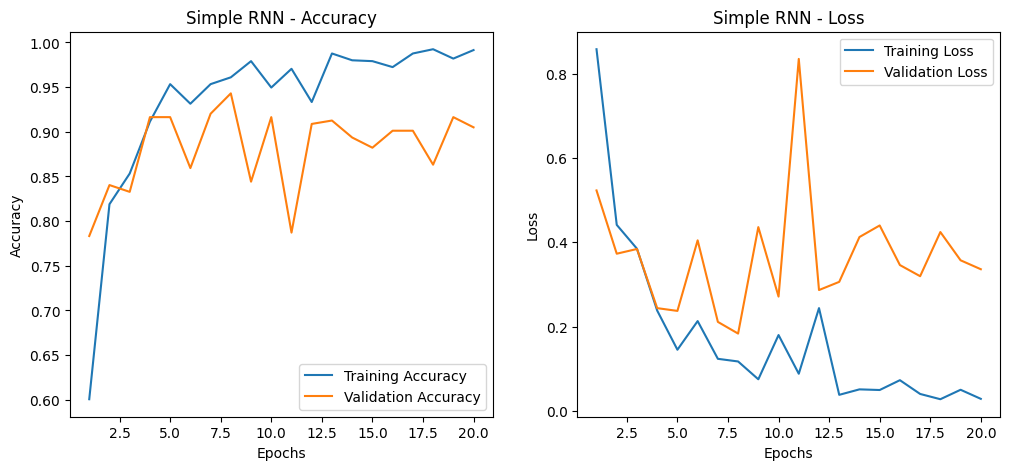

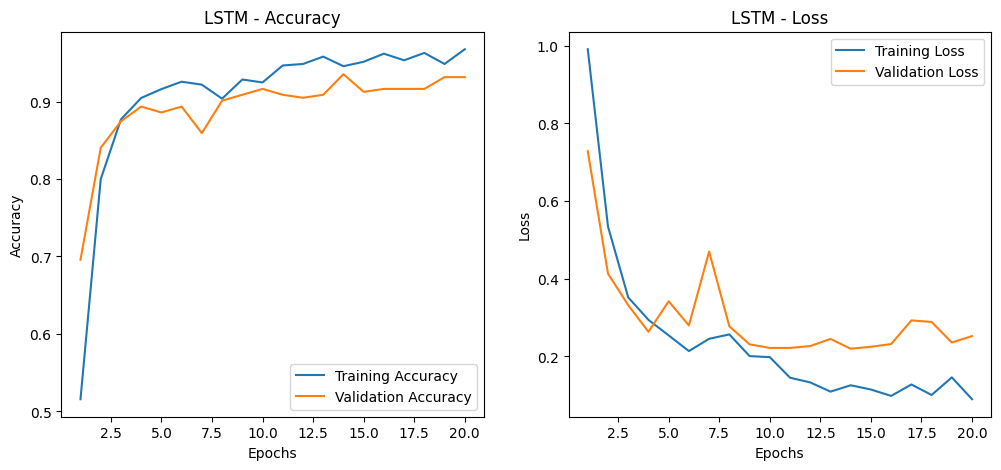

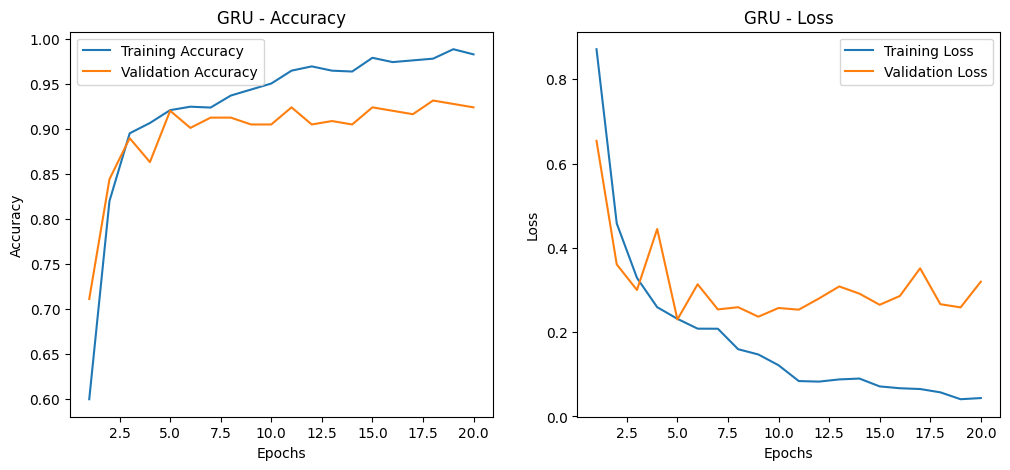

In [94]:
# Function to plot training & validation accuracy/loss
def plot_history(history, title):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], label='Training Loss')
    plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} - Loss')
    plt.legend()

    plt.show()

# Plot results for each model
plot_history(rnn_history, 'Simple RNN')
plot_history(lstm_history, 'LSTM')
plot_history(gru_history, 'GRU')


In [40]:
# tuner.results_summary()

### Performance after hyperparameter tuning

In [95]:

# Make predictions
test_predictions_rnn = best_rnn_model.predict(test_cnn_data, batch_size=1024, verbose=1)
test_predictions_lstm = best_lstm_model.predict(test_cnn_data, batch_size=1024, verbose=1)
test_predictions_gru = best_gru_model.predict(test_cnn_data, batch_size=1024, verbose=1)

# Define correct sentiment labels
label_map = {
    "positive": "Pos",
    "negative": "Neg",
    "neutral": "Neut"
}

# Convert probabilities to predicted labels
label_names = ["Pos", "Neg", "Neut"]
def get_labels(predictions):
    return [label_names[np.argmax(p)] for p in predictions]

predicted_labels_rnn = get_labels(test_predictions_rnn)
predicted_labels_lstm = get_labels(test_predictions_lstm)
predicted_labels_gru = get_labels(test_predictions_gru)

# Convert actual labels to match predicted format
true_labels = data_test['sentiment'].map(label_map)

# Calculate accuracy using NumPy
accuracy_rnn = np.mean(np.array(true_labels) == np.array(predicted_labels_rnn))
accuracy_lstm = np.mean(np.array(true_labels) == np.array(predicted_labels_lstm))
accuracy_gru = np.mean(np.array(true_labels) == np.array(predicted_labels_gru))

# Print results
print(f"✅ RNN Accuracy: {accuracy_rnn:.4f}")
print(f"✅ LSTM Accuracy: {accuracy_lstm:.4f}")
print(f"✅ GRU Accuracy: {accuracy_gru:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
✅ RNN Accuracy: 0.8973
✅ LSTM Accuracy: 0.9521
✅ GRU Accuracy: 0.9315


In [96]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Calculate precision, recall, and F1 score for each model
def evaluate_model(true_labels, predicted_labels, model_name):
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    
    print(f"📊 {model_name} Evaluation:")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(classification_report(true_labels, predicted_labels, target_names=label_names))

# Evaluate RNN
evaluate_model(true_labels, predicted_labels_rnn, "RNN")

# Evaluate LSTM
evaluate_model(true_labels, predicted_labels_lstm, "LSTM")

# Evaluate GRU
evaluate_model(true_labels, predicted_labels_gru, "GRU")

📊 RNN Evaluation:
  Precision: 0.9005
  Recall: 0.8973
  F1 Score: 0.8976

Classification Report:
              precision    recall  f1-score   support

         Pos       0.92      0.96      0.94        49
         Neg       0.82      0.87      0.85        47
        Neut       0.96      0.86      0.91        50

    accuracy                           0.90       146
   macro avg       0.90      0.90      0.90       146
weighted avg       0.90      0.90      0.90       146

📊 LSTM Evaluation:
  Precision: 0.9556
  Recall: 0.9521
  F1 Score: 0.9526

Classification Report:
              precision    recall  f1-score   support

         Pos       1.00      0.96      0.98        49
         Neg       0.88      0.98      0.93        47
        Neut       0.98      0.92      0.95        50

    accuracy                           0.95       146
   macro avg       0.95      0.95      0.95       146
weighted avg       0.96      0.95      0.95       146

📊 GRU Evaluation:
  Precision: 0.9332
  R

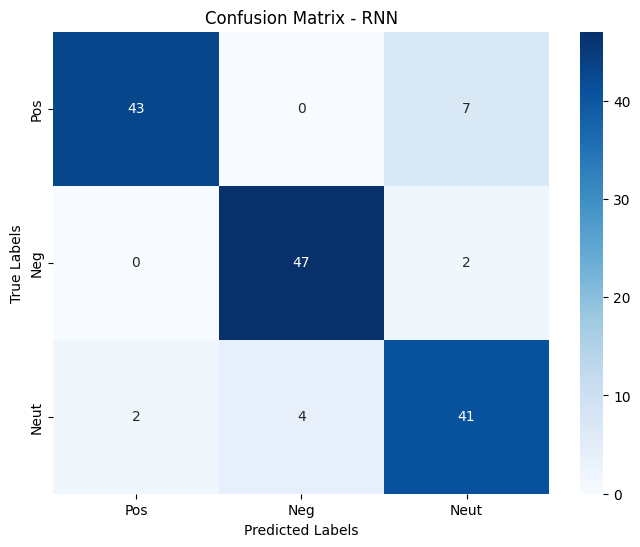

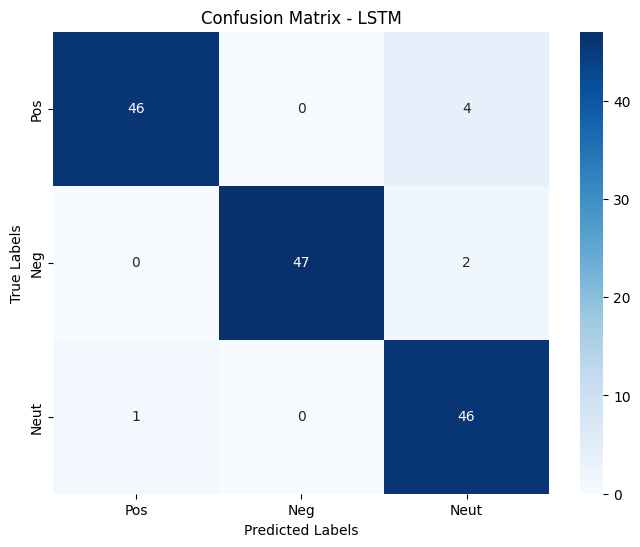

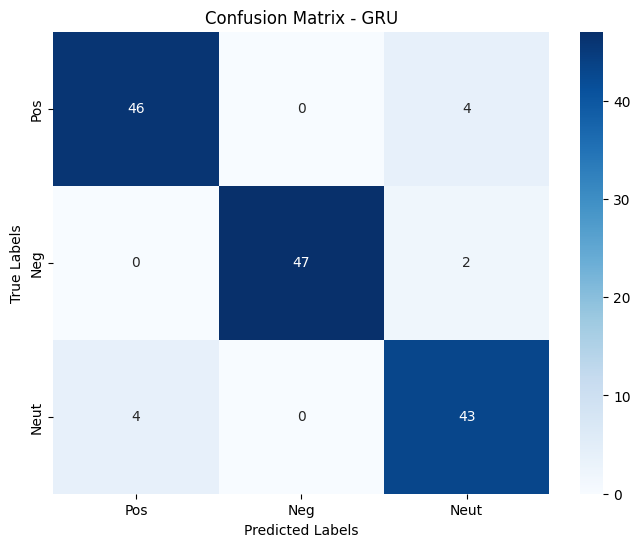

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(true_labels, predicted_labels, model_name, classes):
    cm = confusion_matrix(true_labels, predicted_labels, labels=classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Plot confusion matrices for each model
plot_confusion_matrix(true_labels, predicted_labels_rnn, "RNN", label_names)
plot_confusion_matrix(true_labels, predicted_labels_lstm, "LSTM", label_names)
plot_confusion_matrix(true_labels, predicted_labels_gru, "GRU", label_names)

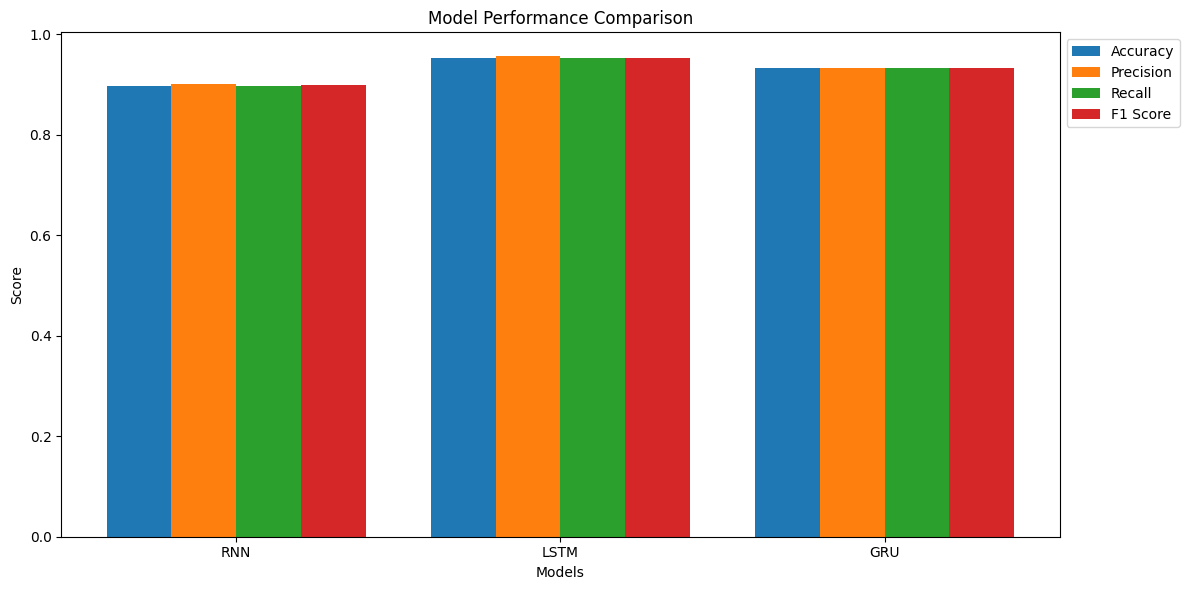

In [98]:
import numpy as np

# Calculate metrics for all models
def get_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
    return accuracy, precision, recall, f1

# Get metrics for each model
metrics_rnn = get_metrics(true_labels, predicted_labels_rnn)
metrics_lstm = get_metrics(true_labels, predicted_labels_lstm)
metrics_gru = get_metrics(true_labels, predicted_labels_gru)

# Organize metrics for plotting
models = ['RNN', 'LSTM', 'GRU']
metrics = {
    'Accuracy': [metrics_rnn[0], metrics_lstm[0], metrics_gru[0]],
    'Precision': [metrics_rnn[1], metrics_lstm[1], metrics_gru[1]],
    'Recall': [metrics_rnn[2], metrics_lstm[2], metrics_gru[2]],
    'F1 Score': [metrics_rnn[3], metrics_lstm[3], metrics_gru[3]]
}

# Plotting
x = np.arange(len(models))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
for i, (metric_name, values) in enumerate(metrics.items()):
    ax.bar(x + i * width, values, width, label=metric_name)

# Add labels, title, and legend
ax.set_xlabel('Models')
ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(models)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [122]:
import tensorflow as tf
from tensorflow import keras

# Force TensorFlow to use CPU
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # Disables GPU

# Load the model
# model = keras.models.load_model("model.h5")

# Verify if running on CPU
print("Device being used:", tf.config.list_physical_devices('GPU'))


Device being used: []
